# Artificial Neural Networks (ANNs)<br><sub>Author: Greg Holste<br></sub>

**Artificial neural networks** (ANNs) are a class of statistical models based loosely on biological neuronal networks. The subject of this notebook, *feedforward* neural networks, can be used for supervised classification or regression and are often represented by a directed graph in which nodes (called artificial *neurons*) are connected by edges (called *weights*). Neurons are arranged in vertical "layers," and weights connect each neuron to every neuron in the following layer. More on this later, but first let's focus on the primary unit of an artificial neural network: the neuron.

## The Artificial Neuron

![neuron](Figs/neuron.png)

Mathematically, a neuron essentially computes the dot product of incoming inputs and weights. That is, the output of the above neuron is $z = x_1w_1 + x_2w_2 + x_3w_3 = {\bf x \cdot w}$, where each $x_k$ is an input feature and each $w_k$ is the *weight* associated with $x_k$, roughly representing the contribution of $x_k$. Typically this output is passed through an **activation function** $a: \mathbb{R} \to [0, 1]$, which can be interpreted as the *strength* of the neuron firing. (Note that this is very much NOT how biological neurons work... they are binary!)

A common activation is the *sigmoid function* $\sigma(z) = \frac{1}{1 + e^{-z}}$ since it introduces non-linearity and has a simple derivative (we will see later why this is desirable). So if we apply a sigmoid activation to the above neuron, we could write that our neuron's *activation* is $a = \sigma(\sum_{k=1}^3 x_kw_k) = \sigma({\bf x \cdot w})$.

## Network Structure 

But this is just one neuron... an actual neural net contains many fully connected layers of neurons. A typical feedforward network consists of an *input layer*, one or more *hidden layers*, and an *output layer* (where a prediction is made). The input layer is of course where our data are fed into the network, so really only the hidden and output layers consist of neurons as defined above.

![network](Figs/ann_architecture.png)

Hidden layers are simply layers that are neither input nor output layers. So when people talk about "deep" learning or "deep" neural networks, they are typically referring to neural nets with multiple hidden layers.

To be a little more careful about notation, suppose we have $L$ layers, from the first hidden layer to the output. Then $h_k^{(l)}$ is the $k$-th neuron in the $l$-th layer. Similarly, $w_{k,j}^{(l)}$ is the weight from the $j$-th neuron (or input) in the $(l-1)$-th layer to the $k$-th neuron in layer $l$. So we could write that the output for the above network is $$\hat{f}({\bf x}) = \sigma( {\bf w^{(3)}} \cdot \sigma( {\bf w^{(2)}} \cdot \sigma({\bf x \cdot w^{(1)}}) ))$$

## Training: The Basics

How do we actually train, or fit, this model? First we must define a **loss function** (also called an "objective" or "cost" function) that assesses the quality of our model's predictions. A simple choice would be mean-squared-error (MSE), $C(y, \hat{y}) = \frac{1}{2n} \sum_{i=1}^n (y_i - \hat{y_i})^2$, since it has a simple derivative (for a single prediction) $C' = y - \hat{y}$.

Now suppose we randomly initalize all our weights and feed each of our observations through the network as described above. This would give $n$ predictions, which will probably be terrible since we are essentially feeding our data through random noise. The basic question is then... how do we best tweak our weights to decrease loss (and thus improve the quality of our results)? It turns out the answer is given to us by calculus!

The (negative) **gradient** of our loss, $-\nabla C$, gives the *direction of steepest descent* in our "cost space." That is, the components of this gradient – the partial derivatives with respect to each weight – actually tell us how to update each weight such that loss will decrease.

Then we can use the simple update rule $$w_k \gets w_k - \lambda \frac{\partial C}{\partial w_k},\ l = 1, \dots, L;\ k = 1, \dots, n_l,$$ where $n_l$ is the number of neurons in the $l$-th layer and $\lambda$ is the *learning rate*. Visually, one can interpret $\lambda$ as the "step size" in our cost space, measuring how far in the direction of steepest descent we travel each time we update our weights.

At a high level, we (1) feed data through the network, (2) compute our loss and gradient, (3) update our weights, and (4) repeat steps (1)-(3) until convergence. Of course it is not this simple, and deciding when to stop training is not trivial, but that's the gist of it.

## Training: Stochastic Gradient Descent

Typically it is difficult to compute -$\nabla C$ for *every* observation, so instead we will compute the gradient for smaller subsets of $m < n$ observations at a time, called **mini-batches**. This allows us to get a good estimate of the true gradient over the entire training set while vastly speeding up training time; specifically, we are assuming the **batch size** $m$ is large enough that $$\nabla C \approx \frac{1}{m} \sum_{i=1}^m \nabla C(y, \hat{f}({\bf x_i})).$$

Then our new update rule is given by $$w_k \gets w_k - \frac{\lambda}{m} \sum_{i=1}^m \frac{\partial C(y, \hat{f}({\bf x_i}))}{\partial w_k},\ l = 1, \dots, L;\ k = 1, \dots, n_l.$$ So to train our neural network we...
1. Randomly select a mini-batch of $m$ observations
2. Feedforward and compute $\nabla C(y, \hat{f}({\bf x_i})),\ i = 1, \dots, m$
3. Update weights via above equation
4. Repeat steps 1-3 until exhausted training set
5. Repeat steps 1-4 until convergence (or some other stopping condition).

This algorithm for training neural nets is called **stochastic gradient descent** (SGD) since we randomly (stochastically) choose mini-batches of data to learn from and use the gradient of our loss to update weights. Lastly, the actual details of updating weights will be left out of this notebook; essentially, we use an algorithm called [backpropagation](https://en.wikipedia.org/wiki/Backpropagation), which uses the chain rule to propagate errors backward and update weights from output to first layer.

Each time we hit step 4, when we have made a full pass through the training set, we say we have completed one **epoch**. One way to determine when to stop training is simply to set a fixed number of epochs to train. We can see that the batch size, number of epochs, and learning rate are three basic hyperparameters of a neural net that can be tuned. There is an inherent trade-off between learning rate and number of epochs; put simply, one can either take many tiny steps in the cost space or only a few large steps. As always, there is more to it, but for now let's actually solve a problem using a neural network.

## A Simple Application

Now we will use our neural network implementation (in `ANN.py`) to classify handwritten digits. This dataset (MNIST) contains hundreds of thousands of labeled, handwritten digits and has become a standard toy data set for machine learning methods. This is an example of a very simple *computer vision* task.

In [70]:
from ANN import *
from tensorflow.keras.datasets.mnist import load_data
import matplotlib.pyplot as plt
from sklearn.metrics import confusion_matrix
from mlxtend.plotting import plot_confusion_matrix

train_data, test_data = load_data(path='mnist.npz')
print(f"{train_data[0].shape[0]} training images (each {train_data[0].shape[1]} x {train_data[0].shape[2]})")
print(f"{test_data[0].shape[0]} testing images (each {test_data[0].shape[1]} x {test_data[0].shape[2]})")

60000 training images (each 28 x 28)
10000 testing images (each 28 x 28)


Here are a few examples of training images. They are low-resolution (28 x 28 pixels) grayscale images. This means they contain one color channel and pixel intensity values range from $0$ to $255$; in other words, they are encoded in 8 bits.

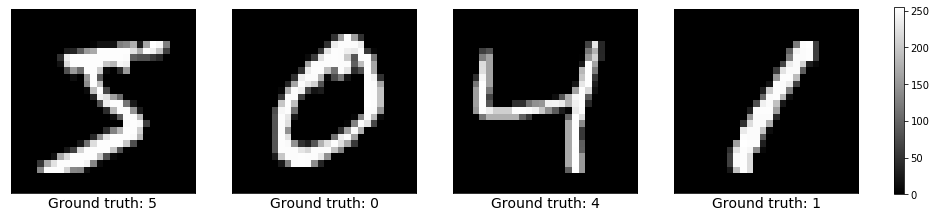

In [72]:
fig, ax = plt.subplots(1, 4, figsize=(16, 4))
for i in range(4):
    im = ax[i].imshow(train_data[0][i], cmap=plt.cm.gray, vmin=0, vmax=255)
    ax[i].set_xticks([]), ax[i].set_yticks([])
    ax[i].set_xlabel(f"Ground truth: {train_data[1][i]}", fontsize=14)
fig.colorbar(im, ax=ax, fraction=0.0105, pad=0.04)
plt.show()

We must convert our data to the proper format for our neural net implementation in `ANN.py`. To use these images as inputs, we will flatten them (convert each $28 \times 28$ matrix into a $784 \times 1$ vector) and **normalize** the  pixel values (rescale to the interval $[0, 1]$). This is a common pre-processing step since (1) it ensures all features are on the same scale (which is unnecessary in this particular case of pixel intensities) and (2) it leads to faster convergence by avoiding neuron "saturation" (where large values cause large sigmoid activations, which have very small gradients, meaning the neuron becomes effectively "stuck" at $1$ or $0$ – the extremes of the sigmoid range).

We also will **one-hot encode** the labels. This means, for example, $Y=4$ becomes $Y=(0, 0, 0, 1, 0, 0, 0, 0, 0)$. One can interpret these one-hot-encoded labels as vectors whose elements are binary indicators of class membership. So $Y=(1, 0, \dots, 0)$ means that this observation *does* belong to class 0 (it is an image of a zero) and *not* to class 1, \dots, and *not* to class 9.

In [4]:
training_data = [(normalize(x.ravel()[:, np.newaxis]), one_hot(y, 10))
                 for x, y in zip(train_data[0], train_data[1])]
testing_data = [(normalize(x.ravel()[:, np.newaxis]), one_hot(y, 10))
                for x, y in zip(test_data[0], test_data[1])]

(784, 1)
(10, 1)


Create a neural net with a single hidden layer of 32 sigmoid neurons and an output layer of 10 sigmoid neurons (for our 10 output classes). Then train for 10 epochs using mini-batches of 10 images at a time via SGD with $\lambda=1$.

In [32]:
NN = NeuralNet([784, 32, 10], y_type="discrete")
NN.train(training_data, batch_size=10, epochs=10, lr=1.)

Epoch 10 | Accuracy: 0.974: 100%|██████████| 10/10 [01:02<00:00,  6.49s/it]


We see after 10 epochs, our neural net correctly classifies $97.4\%$ of training images correctly... but how does it perform on the test set?

In [33]:
print(f"{round(NN.evaluate(testing_data) * 100, 3)}% accuracy on the test set")

0.9622


Seems pretty good! Let's look at a confusion matrix to get a bird's eye view of the types of misclassifications our model makes.

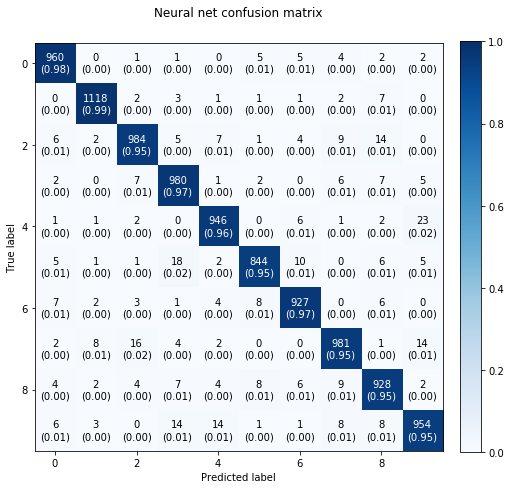

In [67]:
y_pred = NN.predict([x for x, _ in testing_data])
y_true = np.array([np.argmax(y) for _, y in testing_data])

cm = confusion_matrix(y_true, y_pred)
fig, ax = plot_confusion_matrix(cm, show_normed=True, colorbar=True, figsize=(8, 8))
ax.set_xlabel("Predicted label")
ax.set_ylabel("True label")
ax.set_title("Neural net confusion matrix")
plt.show()

Finally, let's examine some of our models predictions on the test set, particularly looking for misclassifications.

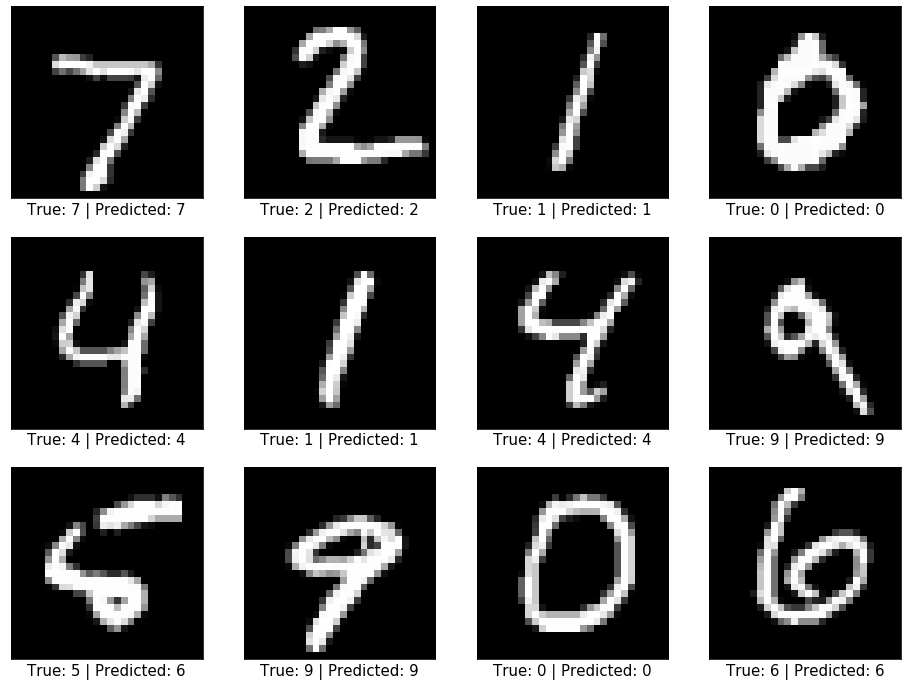

In [63]:
y_pred = NN.predict([x for x, _ in testing_data[:12]])
y_true = [np.argmax(y) for _, y in testing_data[:12]]

fig = plt.figure(figsize=(16, 12))
for i in range(12):
    fig.add_subplot(3, 4, i + 1)
    plt.imshow(test_data[0][i], cmap=plt.cm.gray)
    plt.xticks([]), plt.yticks([])
    plt.xlabel(f"True: {y_true[i]} | Predicted: {y_pred[i]}", fontsize=15)

We see the bottom left number was misclassified as a 6, though in fairness I wouldn't have been so sure that was a 5 either!

## Concluding Remarks

This was a high-level introduction to the basics of feedforward neural nets. I keep specifying "feedforward" because it is possible to have neurons whose outputs are actually fed back into themselves as input. That is, our network does not need to be a directed graph; this is called a *recurrent* neural network (RNN).

For simplicity, I have neglected to mention the **bias** term. Similar to the intercept in a linear regression model, we usually include a single bias term in each layer, which can be represented as a neuron that always outputs $1$ and has no incoming connections, but is fully connected to the weights of the following layer. To accomodate the bias term during training, we simply update its weights as well via $$b_l \gets b_l - \lambda \frac{\partial C}{\partial b_l},\ l = 1, \dots, L.$$

Also, to co-opt our simple neural network for regression, we simply remove the sigmoid activation at the output layer and proceed normally. Put another way, we apply a "linear" (identity) activation to our single output neuron so that we do not constrain the output to $[0,1]$.

Lastly, while we only considered neural nets of sigmoid-activated layers trained with stochastic gradient descent, there are of course many other activations... many other loss functions... many other optimization (training) algorithms... and so on. To give one example, some alternatives to SGD find clever ways to dynamically change $\lambda$ *during* training based on our location in the cost space.